#### mucking about with custom trajectories - 20250225 CJH

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d, CubicSpline, PchipInterpolator
np.set_printoptions(formatter={'float': lambda x: "{0:0.2f}".format(x)})

In [75]:
trajectory.waypoint_violations

{0: {'elevator': 'acc', 'pivot': None, 'wrist': 'acc', 'intake': None},
 0.25: {'elevator': 'acc', 'pivot': None, 'wrist': 'acc', 'intake': None},
 0.5: {'elevator': 'acc', 'pivot': None, 'wrist': 'acc', 'intake': None},
 1: {'elevator': 'acc', 'pivot': None, 'wrist': 'acc', 'intake': None},
 1.5: {'elevator': 'acc', 'pivot': None, 'wrist': 'acc', 'intake': None},
 2: {'elevator': 'acc', 'pivot': None, 'wrist': 'acc', 'intake': None},
 2.5: {'elevator': None, 'pivot': None, 'wrist': None, 'intake': None}}

In [119]:
class CustomTrajectory:
    def __init__(self, waypoints, duration, interpolation_type="linear", velocity_constraints=None, acceleration_constraints=None, name='test'):
        self.name = name
        self.duration = duration
        self.interpolation_type = interpolation_type  # Store interpolation method
        self.time_steps = np.linspace(0, duration, int(duration / 0.01) + 1)
        self.keys = ['elevator', 'pivot', 'wrist', 'intake']
        self.servo_columns = {'intake'}  # Default servo column
        self.waypoints = dict(sorted(waypoints.items()))  # Store waypoints for later reuse
        self.trajectory = {key: [] for key in self.keys}
        self.velocity_constraints = velocity_constraints if velocity_constraints else {key: 0 for key in self.keys}
        self.acceleration_constraints = acceleration_constraints if acceleration_constraints else {key: 0 for key in self.keys}
        self.generate_trajectory()  # Generate the initial trajectory
        self.check_constraints()
    
    def generate_trajectory(self):
        times = np.array(list(self.waypoints.keys()))
        for key in self.keys:
            values = np.array([self.waypoints[t][key] for t in times]).astype(float)
            if key in self.servo_columns:
                # Servo behavior: use stepwise constant values
                step_values = np.zeros_like(self.time_steps)
                for i, t in enumerate(self.time_steps):
                    step_values[i] = values[np.searchsorted(times, t, side='right') - 1]
                self.trajectory[key] = step_values.astype(float)
            else:
                # Normal interpolation
                if self.interpolation_type == "linear":
                    interp_func = interp1d(times, values, kind='linear', fill_value='extrapolate')
                elif self.interpolation_type == "cubic":
                    interp_func = CubicSpline(times, values, bc_type='natural')
                elif self.interpolation_type == "pchip":
                    interp_func = PchipInterpolator(times, values)
                else:
                    raise ValueError(f"Unsupported interpolation type: {self.interpolation_type}")
                self.trajectory[key] = interp_func(self.time_steps).astype(float)
    
    def set_constraints(self, velocity_constraints=None, acceleration_constraints=None):
        """ Adds constraints of the form  
         velocity_constraints = {'elevator':1, 'pivot':1, 'wrist':1, 'intake'0 } 
         acceleration_constraints = {'elevator':1, 'pivot':1, 'wrist':1, 'intake'0 } 
        """
        if velocity_constraints:
            self.velocity_constraints = velocity_constraints
        if acceleration_constraints:
            self.acceleration_constraints = acceleration_constraints
        self.check_constraints()
    
    def check_constraints_old(self):
        """ Checks if velocity and acceleration constraints are violated and records violations """
        self.waypoint_violations = {t: {key: None for key in self.keys} for t in self.waypoints}
        self.speeds = {key: {'velocity': [], 'acceleration': []} for key in self.keys}
        for key in self.keys:
            if len(self.trajectory[key]) > 1:
                vel = np.gradient(self.trajectory[key], self.time_steps)
                acc = np.gradient(vel, self.time_steps)
                vel[0] = 0  # Ensure initial condition matches waypoint
                acc[0] = 0  # Ensure initial condition matches waypoint
                self.speeds[key]['velocity'] = vel
                self.speeds[key]['acceleration'] = acc
                for i in range(1, len(self.time_steps)):
                    for t in self.waypoints:
                        if self.time_steps[i] >= t:
                            if self.velocity_constraints[key] and abs(vel[i]) > self.velocity_constraints[key]:
                                if self.waypoint_violations[t][key] is None:
                                    self.waypoint_violations[t][key] = []
                                self.waypoint_violations[t][key].append('vel')
                            if self.acceleration_constraints[key] and abs(acc[i]) > self.acceleration_constraints[key]:
                                if self.waypoint_violations[t][key] is None:
                                    self.waypoint_violations[t][key] = []
                                self.waypoint_violations[t][key].append('acc')
                for t in self.waypoints:
                    if self.waypoint_violations[t][key]:
                       self.waypoint_violations[t][key] = set(self.waypoint_violations[t][key])
        
        violations_exist = any(any(v is not None for v in self.waypoint_violations[t].values()) for t in self.waypoints)
        if violations_exist:
            print("Waypoint Violations:")
            print("Time      | " + " | ".join(self.keys))
            print("-" * (12 + 4 * len(self.keys)))
            for t, violations in self.waypoint_violations.items():
                row = [f"{t:8.2f}"] + [', '.join(violations[key]) if violations[key] else "None" for key in self.keys]
                print(" | ".join(row))
        else:
            print("No Waypoint Violations:")

     def check_constraints(self):
        """ Checks if velocity and acceleration constraints are violated and records violations """
        self.speeds = {t:{velocity:0, acceleration:0} for t in self.time_steps}
    
    def set_interpolation_type(self, new_type):
        """ Change interpolation type and regenerate trajectory """
        self.interpolation_type = new_type
        self.generate_trajectory()  # Recompute the trajectory with new method
    
    def get_value(self, t):
        """ Returns a dictionary of setpoint values for any given time in the trajectory """
        if t < 0: t = 0
        if t > self.duration: t = self.duration
        idx = np.searchsorted(self.time_steps, t)
        if idx == 0:
            return {key: float(self.trajectory[key][0]) for key in self.keys}
        elif idx >= len(self.time_steps):
            return {key: float(self.trajectory[key][-1]) for key in self.keys}
        else:
            t1, t2 = self.time_steps[idx - 1], self.time_steps[idx]
            values = {}
            for key in self.keys:
                if key in self.servo_columns:
                    values[key] = float(self.trajectory[key][idx])
                else:
                    v1, v2 = self.trajectory[key][idx - 1], self.trajectory[key][idx]
                    values[key] = float(v1 + (v2 - v1) * (t - t1) / (t2 - t1))
            return values
    
    def check_trajectory(self, wrist_safe_pivot=(-70, 70), wrist_safe_elevator=1):
        """ See if trajectory ever violates wrist safety constraints"""
        collisions = []
        for i, t in enumerate(self.time_steps):
            pivot, elevator, wrist = self.trajectory['pivot'][i], self.trajectory['elevator'][i], self.trajectory['wrist'][i]
            if wrist != 0 and not (pivot < wrist_safe_pivot[0] or pivot > wrist_safe_pivot[1] or elevator > wrist_safe_elevator):
                collisions.append(t)
        return collisions
    
    def fix_trajectory(self, wrist_safe_pivot=(-70, 70), wrist_safe_elevator=1):
        """ Adjusts the trajectory to ensure the wrist does not move until it is safe. 
            NOTE - does not work yet  """
        fixed_trajectory = {key: self.trajectory[key].copy().astype(float) for key in self.keys}
        
        for i, t in enumerate(self.time_steps):
            pivot, elevator, wrist = fixed_trajectory['pivot'][i], fixed_trajectory['elevator'][i], fixed_trajectory['wrist'][i]
            if wrist != 0 and not (pivot < wrist_safe_pivot[0] or pivot > wrist_safe_pivot[1] or elevator > wrist_safe_elevator):
                fixed_trajectory['wrist'][i] = fixed_trajectory['wrist'][i-1] if i > 0 else 0.0
        
        self.trajectory = fixed_trajectory
    
    def rescale_trajectory(self, new_duration):
        """ Rescales the trajectory to fit a new duration while maintaining relative timing of waypoints. """
        scale_factor = new_duration / self.duration
        new_waypoints = {t * scale_factor: v for t, v in self.waypoints.items()}
        self.duration = new_duration
        self.time_steps = np.linspace(0, new_duration, int(new_duration / 0.01) + 1)
        self.waypoints = dict(sorted(new_waypoints.items()))
        self.generate_trajectory()

    
    def visualize_trajectory(self):
        fig, ax = plt.subplots(figsize=(8, 6))
        colors = {'elevator': 'blue', 'pivot': 'red', 'wrist': 'green', 'intake': 'purple'}
        limits = {'elevator': (0, 2), 'pivot': (-45, 135), 'wrist': (-90, 180), 'intake': (-5, 5)}

        twins= [ax.twinx(), ax.twinx(), ax.twinx()]
        for idx in range(4):
            if idx ==0 :
                axis = ax
                ax.set_xlabel('Time (s)')
            else:
                axis = twins[idx-1]
            if idx > 1:
                axis.spines['right'].set_position(('outward', 60*(idx-1)))
            key = list(colors.keys())[idx]
            axis.set_ylabel(key, color=colors[key])
            axis.plot(self.time_steps, self.trajectory[key], color=colors[key], label=key)
            axis.scatter(list(self.waypoints.keys()), [ self.waypoints[k][key] for k in self.waypoints.keys() ], color=colors[key], s=10, edgecolors='black', zorder=3)
            axis.set_ylim(limits[key])
            axis.tick_params(axis='y', labelcolor=colors[key])

        fig.suptitle(f'Plot of trajectory "{self.name}"', y=.95)
        fig.tight_layout()
        plt.show()
    
    def sparkline(self, length=50):
          blocks = "▁▂▃▄▅▆▇█"
          colors = {'elevator': '\033[34m', 'pivot': '\033[31m', 'wrist': '\033[32m', 'intake': '\033[35m'}
          limits = {'elevator': (0, 2), 'pivot': (-45, 135), 'wrist': (-90, 180), 'intake': (-5, 5)}
          
          spark_lines = []
          for key in self.keys:
              min_val, max_val = limits[key]
              normalized = np.interp(self.trajectory[key], [min_val, max_val], [0, 7]).astype(int)
              line = ''.join(blocks[val] for val in normalized[::len(normalized)//length])
              spark_lines.append(f"{colors[key]}{line}\033[0m")
          
          return '\n'.join(spark_lines)


Waypoint Violations:
Time      | elevator | pivot | wrist | intake
----------------------------
    0.00 | vel | acc | acc, vel | None
    0.25 | vel | acc | acc, vel | None
    0.50 | vel | None | acc, vel | None
    1.00 | vel | None | acc, vel | None
    1.50 | vel | None | acc, vel | None
    2.50 | None | None | acc | None
    3.00 | None | None | None | None


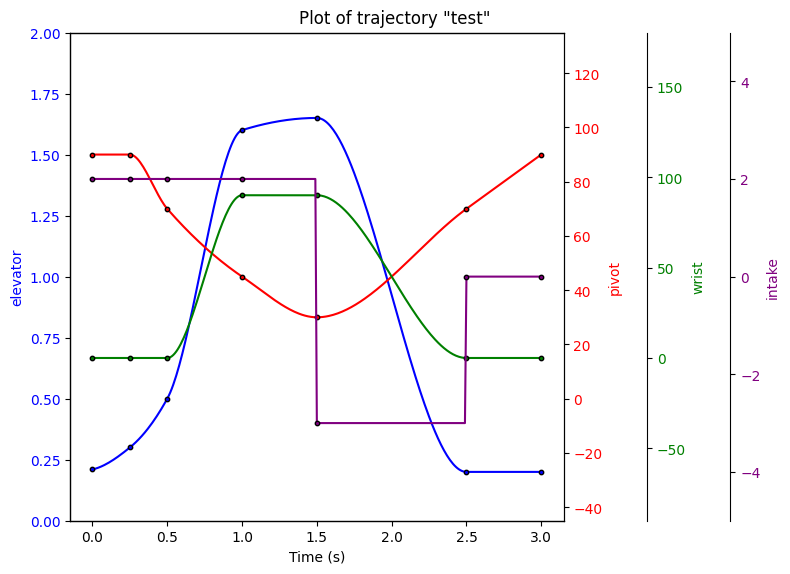

In [264]:
# Example Usage:
waypoints = {
    0: {'elevator': 0.21, 'pivot': 90, 'wrist': 0, 'intake': 2},  # start 
    0.25: {'elevator': 0.3, 'pivot': 90, 'wrist': 0, 'intake': 2},  # start 
    0.5: {'elevator':0.5, 'pivot': 70, 'wrist': 0, 'intake': 2},  # get to safe wrist
    1: {'elevator': 1.6, 'pivot': 45, 'wrist': 90, 'intake': 2},  # get to scoring wrist
    1.5: {'elevator': 1.65, 'pivot': 30, 'wrist': 90, 'intake': -3},  # move pivot while scoring
    2.5: {'elevator': 0.2, 'pivot': 70, 'wrist': 0, 'intake': 0},  # return home with wrist safe
    3.0: {'elevator': 0.2, 'pivot': 90, 'wrist': 0, 'intake': 0},  # come down to bottom
}
velocity_constraints = {'elevator':1.5, 'pivot':1000, 'wrist':90, 'intake':0 }
acceleration_constraints = {'elevator': 20, 'pivot':1000, 'wrist':180, 'intake':0 }
# linear, pchip, cubic
trajectory = CustomTrajectory(waypoints, duration=3, interpolation_type="pchip", 
                              velocity_constraints=velocity_constraints, acceleration_constraints=acceleration_constraints)

trajectory.visualize_trajectory()
# trajectory.check_constraints()

In [265]:
#trajectory.speeds

In [266]:
print("value at 1.5: ", trajectory.get_value(1.5))
print("Collisions:", trajectory.check_trajectory())

print(r"Sparkline:")
print(trajectory.sparkline())

value at 1.5:  {'elevator': 1.65, 'pivot': 30.0, 'wrist': 90.0, 'intake': -3.0}
Collisions: [np.float64(0.51), np.float64(0.52), np.float64(0.53), np.float64(0.54), np.float64(0.55), np.float64(0.56), np.float64(0.5700000000000001), np.float64(0.58), np.float64(0.59), np.float64(0.6), np.float64(0.61), np.float64(0.62), np.float64(0.63), np.float64(0.64), np.float64(0.65), np.float64(0.66), np.float64(0.67), np.float64(0.68), np.float64(0.6900000000000001), np.float64(0.7000000000000001), np.float64(0.71), np.float64(1.97), np.float64(1.98), np.float64(1.99), np.float64(2.0), np.float64(2.0100000000000002), np.float64(2.02), np.float64(2.0300000000000002), np.float64(2.04), np.float64(2.05), np.float64(2.06), np.float64(2.07), np.float64(2.08), np.float64(2.09), np.float64(2.1), np.float64(2.11), np.float64(2.12), np.float64(2.13), np.float64(2.14), np.float64(2.15), np.float64(2.16), np.float64(2.17), np.float64(2.18), np.float64(2.19), np.float64(2.2), np.float64(2.21), np.float64(2.

In [267]:
#trajectory.rescale_trajectory(new_duration=1)
#trajectory.visualize_trajectory()

In [268]:
#trajectory.fix_trajectory()
#trajectory.visualize_trajectory()

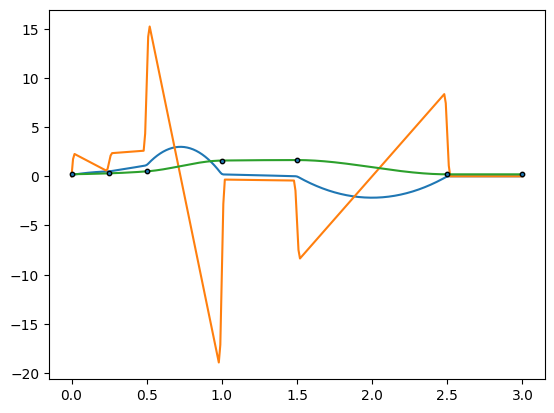

In [269]:
key = 'elevator'
plt.plot(trajectory.time_steps, trajectory.speeds[key]['velocity'])
plt.plot(trajectory.time_steps, trajectory.speeds[key]['acceleration'])
plt.plot(trajectory.time_steps, trajectory.trajectory[key])
plt.scatter(list(trajectory.waypoints.keys()), [ trajectory.waypoints[k][key] for k in trajectory.waypoints.keys() ], s=10, edgecolors='black', zorder=3)
# plt.plot(trajectory.time_steps, trajectory.speeds['elevator']['acceleration'])

In [259]:
trajectory.check_constraints()

Waypoint Violations:
Time      | elevator | pivot | wrist | intake
----------------------------
    0.00 | vel | acc | acc, vel | None
    0.25 | vel | acc | acc, vel | None
    0.50 | vel | None | acc, vel | None
    1.00 | vel | None | acc, vel | None
    1.50 | vel | None | acc, vel | None
    2.50 | None | None | acc | None
    3.00 | None | None | None | None


In [260]:
import pandas as pd

In [261]:
#pd.DataFrame(trajectory.speeds['elevator'])[::10]

In [270]:
self = trajectory
key = 'elevator'
self.speeds = np.zeros((len(self.time_steps),3))
self.speeds[:,0] = self.time_steps
vel = np.gradient(self.trajectory[key], self.time_steps)
accel = np.gradient(vel, self.time_steps)
window = 30
accel = np.convolve(accel, np.ones(window)/window, mode='same')
self.speeds[:,1]  = vel
self.speeds[:,2]  = accel
self.speeds[::10]
violations = {idx:{'vel':False, 'accel':False} for idx in range(len(self.waypoints))}
for idx, wp in enumerate(self.waypoints):
    next_wp = list(self.waypoints.keys())[idx+1] if idx < (len(self.waypoints)-1) else self.time_steps[-1]
    wp_speeds = self.speeds[(self.speeds[:,0] > wp) & (self.speeds[:,0] < next_wp)]
    wp_speeds = np.abs(wp_speeds)
    #print(wp_speeds)
    #print(wp, next_wp, len(wp_speeds))
    if np.any(wp_speeds[:,1] > self.velocity_constraints[key]):
        violations[idx]['vel'] = True
    if np.any(wp_speeds[:,2] > self.velocity_constraints[key]):
        violations[idx]['accel'] = True
violations

{0: {'vel': False, 'accel': True},
 1: {'vel': False, 'accel': True},
 2: {'vel': True, 'accel': True},
 3: {'vel': False, 'accel': True},
 4: {'vel': True, 'accel': True},
 5: {'vel': False, 'accel': True},
 6: {'vel': False, 'accel': False}}